In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio

# Device configuration
device = torch.device('cuda:'+str(torch.cuda.device_count()-1) if torch.cuda.is_available() else 'cpu')
data_path_root = '/data/wumin/dataset/mnist/'

In [2]:
bs = 100
z_dim = 100

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root=data_path_root, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root=data_path_root, train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 1, 1, 2)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x =  F.leaky_relu(self.deconv1_bn(self.deconv1(input)), 0.2)
        x =  F.leaky_relu(self.deconv2_bn(self.deconv2(x)), 0.2)
        x =  F.leaky_relu(self.deconv3_bn(self.deconv3(x)), 0.2)
        x =  F.leaky_relu(self.deconv4_bn(self.deconv4(x)), 0.2)
        x =  F.tanh(self.deconv5(x))
        
        return x


class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 1, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.dropout(x, 0.3)

        x = F.sigmoid(self.conv5(x))

        return x

        

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [4]:
G, D = Generator().to(device), Discriminator().to(device)
G.weight_init(0, 0.02)
D.weight_init(0, 0.02)

In [5]:
G

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2))
)

In [6]:
D

Discriminator(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [7]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)
y_real, y_fake = torch.ones(bs).to(device), torch.zeros(bs).to(device)

In [8]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real = x.to(device)

    D_output = D(x_real).squeeze()
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on fake
    z = torch.randn((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)
    x_fake = G(z)

    D_output = D(x_fake).squeeze()
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
    
    return  D_loss.data.item()

In [9]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)

    G_output = G(z)
    D_output = D(G_output).squeeze()
    G_loss = criterion(D_output, y_real)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [10]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

In [11]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):

    with torch.no_grad():
        test_z = torch.randn((bs, z_dim)).view(-1, z_dim, 1, 1).to(device)
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, 28, 28),
                   './samples/dcgan/sample_epoch_{}.png'.format(num_epoch), nrow=10)


def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    # display the training losses as epoch increasing
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [12]:
n_epoch = 20
print('training start!')
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.FloatTensor(D_losses).mean(), torch.FloatTensor(G_losses).mean()))
    show_result(epoch)
    
    train_hist['D_losses'].append(torch.FloatTensor(D_losses).mean())
    train_hist['G_losses'].append(torch.FloatTensor(G_losses).mean())

training start!
[1/20]: loss_d: 1.340, loss_g: 0.763
[2/20]: loss_d: 1.141, loss_g: 0.989
[3/20]: loss_d: 1.120, loss_g: 1.064
[4/20]: loss_d: 1.160, loss_g: 1.048
[5/20]: loss_d: 1.228, loss_g: 0.971
[6/20]: loss_d: 1.257, loss_g: 0.932
[7/20]: loss_d: 1.276, loss_g: 0.896
[8/20]: loss_d: 1.291, loss_g: 0.877
[9/20]: loss_d: 1.292, loss_g: 0.866
[10/20]: loss_d: 1.305, loss_g: 0.845
[11/20]: loss_d: 1.308, loss_g: 0.842
[12/20]: loss_d: 1.313, loss_g: 0.830
[13/20]: loss_d: 1.317, loss_g: 0.824
[14/20]: loss_d: 1.316, loss_g: 0.817
[15/20]: loss_d: 1.316, loss_g: 0.818
[16/20]: loss_d: 1.324, loss_g: 0.810
[17/20]: loss_d: 1.318, loss_g: 0.806
[18/20]: loss_d: 1.323, loss_g: 0.811
[19/20]: loss_d: 1.319, loss_g: 0.810
[20/20]: loss_d: 1.320, loss_g: 0.813


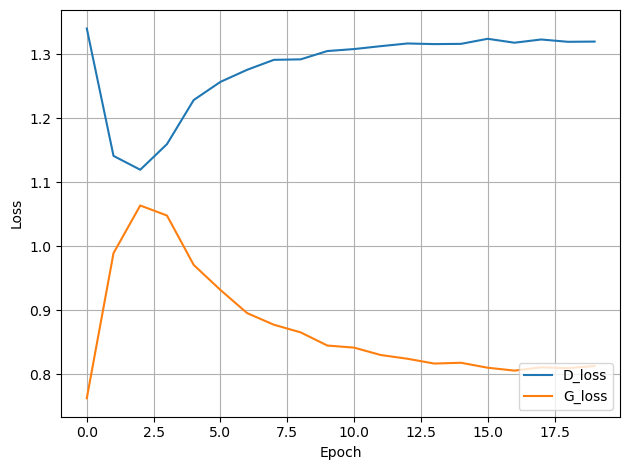

In [13]:
torch.save(G, './models/dcgan_G.pth')
torch.save(D, './models/dcgan_D.pth')
show_train_hist(train_hist, True, True, 'samples/dcgan/history_train_losses.png')

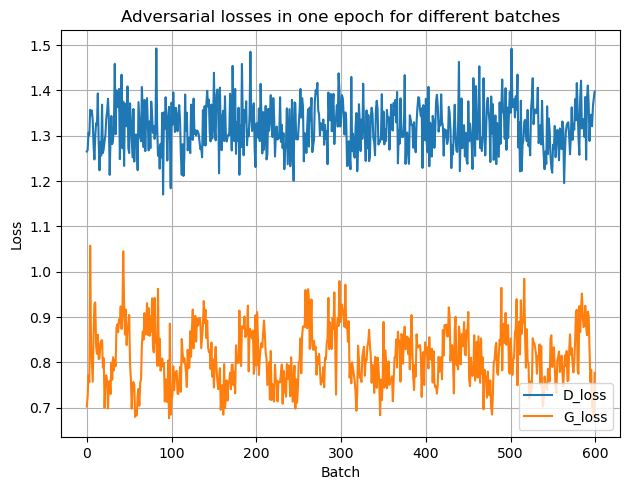

In [14]:
x = range(len(D_losses))
y1 = D_losses
y2 = G_losses

plt.plot(x, y1, label='D_loss')
plt.plot(x, y2, label='G_loss')

plt.xlabel('Batch')
plt.ylabel('Loss')

plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.title('Adversarial losses in one epoch for different batches')
plt.savefig('samples/dcgan/adversarial_losses.png')
plt.show()


In [15]:
images = []
for e in range(n_epoch):
    img_name = 'samples/dcgan/sample_epoch_' + str(e + 1) + '.png'
    images.append(imageio.v2.imread(img_name))
imageio.mimsave('samples/dcgan/generation_animation.gif', images, duration=200)